In [1]:
import matplotlib
import numpy
import torch
import matplotlib.pyplot as plt
import torch.nn.functional as F

from Makemore.classes import *
from Makemore.utils import *
#from Makemore.utils import *

g = torch.Generator().manual_seed(42)


# Andrej Karpathy Lecture Notes

Summarized and modularized first five lectures of "Zero to Hero".

**Goal**: To create a Bigram Model

### Lecture 1: 

- Implement and train a basic bigram model
- Check if we obtain a better loss than a random model

**Result**:
- Random CrossEntropy loss: **2.45**
- Result: **2.503**

In [2]:
# Download data set
words = open("Makemore/names.txt","r").read().splitlines() 

# Statistic pair characters
b = {} 
for w in words:  
    # For each words compute the occurences of the pairs of characters        
    chs = ["<S>"] + list(w) + ["<S>"]
    for ch1, ch2 in zip(chs, chs[1:]):
        bigram = (ch1,ch2)
        b[bigram] = b.get(bigram,0) + 1

# List characters
chars = sorted(list(set("".join(words)))) 
vocab_size = len(chars) + 1 # Special token
# Dict: Index - Char & Char - Index
stoi  = {ch: 1 + idx for idx, ch in enumerate(chars)} # Dictionary: character to index (starting from 1)
stoi["."] = 0                                         # Assign 0 to special token '.'
itos  = {i: ch for ch, i in stoi.items()}             # Inverse dictionary: index to character

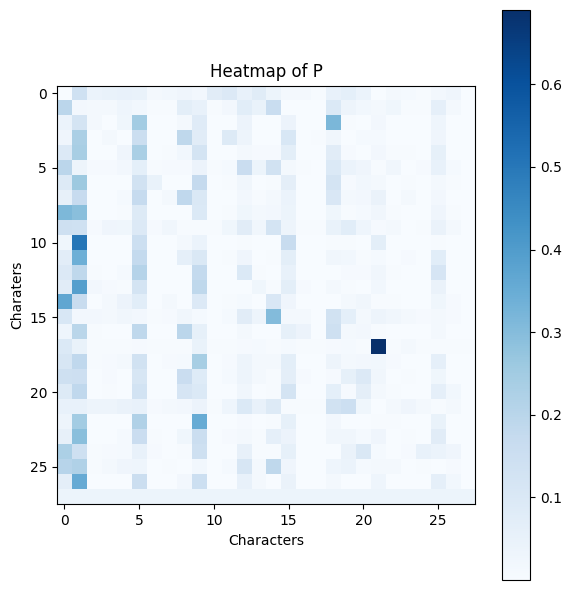

In [3]:
# Vizualisation Markov trans matrix
N = torch.zeros((28,28), dtype = torch.int32) # 28x28 matrix for bigram counts
for w in words:
    chs =  ["."] + list(w) + ["."]
    for ch1, ch2 in zip(chs,chs[1:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        N[ix1,ix2] += 1

P = (N+1).float()
P /=  P.sum(1, keepdims = True)

plt.figure(figsize=(6, 6))                            # Set figure size
plt.imshow(P, cmap='Blues', interpolation='nearest')  # Sharper rendering
plt.colorbar()                                        # Add color scale
plt.title('Heatmap of P')                             # Add title
plt.xlabel('Characters')                              # Label x-axis
plt.ylabel('Charaters')                               # Label y-axis
plt.tight_layout()                                    # Prevent label cutoff
plt.show()


In [4]:
# Generate 5 words
number_words = 5
for i in range(number_words): 
    ix = 0   # index current character
    out = [] # word vector

    while True:
        p = P[ix]                                                                            # probability vector for the next character
        ix = torch.multinomial(p, num_samples = 1, replacement = True, generator = g).item() # index generated for next character 
        out.append(itos[ix])                                                                 # append next character to the word vector
        if ix == 0:
            break
    print("".join(out))

ya.
syahavilin.
dleekahmangonya.
tryahe.
chen.


In [5]:
# Calculate the negative log likelihood (NLL) of the dataset: llhood = 1/N * sum(log(P(w_i|w_{i-1})))
log_likelihood = 0
n              = 0
for w in words:
    chs =  ["."] + list(w) + ["."]
    for ch1, ch2 in zip(chs,chs[1:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        prob = P[ix1,ix2]
        N[ix1,ix2] += 1
        logprob = torch.log(prob)
        log_likelihood += logprob
        n +=1 

nll = -log_likelihood
print(f"Loss is {nll/n}")

Loss is 2.4544754028320312


Check if we can obtain the same loss by training our model

In [6]:
# hyperparameters
num_steps = 1000
lossi = []
# Create training set bigrams (x,y)
xs, ys = [], []

for w in words:
    chs =  ["."] + list(w) + ["."]
    for ch1, ch2 in zip(chs,chs[1:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        xs.append(ix1)
        ys.append(ix2)        
    
xs = torch.tensor(xs)
ys = torch.tensor(ys)

# Randomly initialize the 27 neuron's weight
W = torch.randn((vocab_size, vocab_size), requires_grad = True)

# training loop
for i in range(num_steps):
    # forward pass
    xenc = F.one_hot(xs, num_classes = vocab_size).float()
    logits = xenc @ W # log-counts
    counts = logits.exp() # equivalent N
    probs = counts / counts.sum(1, keepdims = True)
    loss = - probs[torch.arange(logits.shape[0]),ys].log().mean() + 0.01 * (W**2).mean()
    lossi.append(loss.item())
    # backward pass
    W.grad = None
    loss.backward()
    W.data += -3 * W.grad

print(lossi[-1])

2.5029706954956055


In [7]:
# Generate 5 words
for i in range(5):
    ix = 0
    out = []
    while True:
        xenc = F.one_hot(torch.tensor([ix]), num_classes = 27).float()
        logits = xenc @ W # log-counts
        counts = logits.exp() # equivalent N
        probs = counts / counts.sum(1, keepdims = True)
        ix = torch.multinomial(probs, num_samples = 1 , replacement = True, generator = g).item()

        out.append(itos[ix])
        if ix == 0:
            break
    print("".join(out))

ena.
da.
amiiae.
a.
keles.


### Lecture 2,3,4:

- Change architecure: MLP
- Leverage optimization techniques 
- Train Model over 50'000 steps

- Check if we obtain a better loss than a random model

**Result**:
- Previous loss: **2.503**
- Result: **2.31**

In [ ]:
# Hyperparameters
block_size = 3 
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))
n_embd = 10
n_hidden = 100 
max_steps = 50000
batch_size = 32

# Construction data set
Xtr, Ytr   = build_dataset(words[:n1],  block_size, stoi)  # 80%
Xdev, Ydev = build_dataset(words[n1:n2],block_size, stoi)  # 10%
Xte, Yte   = build_dataset(words[n2:],  block_size, stoi)  # 10%


# Model: MLP
C = torch.randn((vocab_size,n_embd), generator = g)
layers = [
    Linear(n_embd * block_size,n_hidden),BatchNorm1D(n_hidden),Tanh(),
    Linear(           n_hidden,n_hidden),BatchNorm1D(n_hidden), Tanh(),
    Linear(           n_hidden,n_hidden),BatchNorm1D(n_hidden),Tanh(),
    Linear(           n_hidden,n_hidden),BatchNorm1D(n_hidden), Tanh(),
    Linear(           n_hidden,n_hidden),BatchNorm1D(n_hidden), Tanh(),
    Linear(           n_hidden,vocab_size), BatchNorm1D(vocab_size),
]

# Strategy
with torch.no_grad():
    # Last layer: make less confident
    layers[-1].gamma *= 0.1
    for layer in layers[:-1]:
        if isinstance(layer,Linear):
            layer.weight *= 5.3 # 5.3

# Keep track parameters
parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(f"There is a total of {sum(p.nelement() for p in parameters)} parameters")
for p in parameters:
    p.requires_grad = True 

In [10]:
# optinization
lossi = []
ud = []

for i in range(max_steps):
    # mini batch construct 
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator = g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

    # forward pass
    emb = C[Xb]                     # embed the characters into vectors
    x = emb.view(emb.shape[0] ,-1)  # concatenate the vectors
    for layer in layers:            # apply the layers
        x = layer(x)
    loss = F.cross_entropy(x,Yb)    # cross entropy loss

    # backward pass
    for layer in layers:
        layer.out.retain_grad()
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # update
    lr = 0.1 if i < 10000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad
    with torch.no_grad():
        ud.append([(lr * p.grad.std() / p.data.std()).log10().item() for p in parameters])
    
    # track stats
    if i %  10000 == 0: # print every once in a while
        print(f"{i:7d}/{max_steps:7d}: {loss.item():.4f}")
    lossi.append(loss.log10().item())

      0/  50000: 3.3049
  10000/  50000: 2.4854
  20000/  50000: 2.2488
  30000/  50000: 2.1853
  40000/  50000: 2.3343


Layer 2 (Tanh): mean +0.51, std 0.52, saturated: 11.03%
Layer 5 (Tanh): mean +0.52, std 0.52, saturated: 12.09%
Layer 8 (Tanh): mean +0.55, std 0.50, saturated: 11.88%
Layer 11 (Tanh): mean +0.54, std 0.51, saturated: 12.28%
Layer 14 (Tanh): mean +0.56, std 0.50, saturated: 12.88%


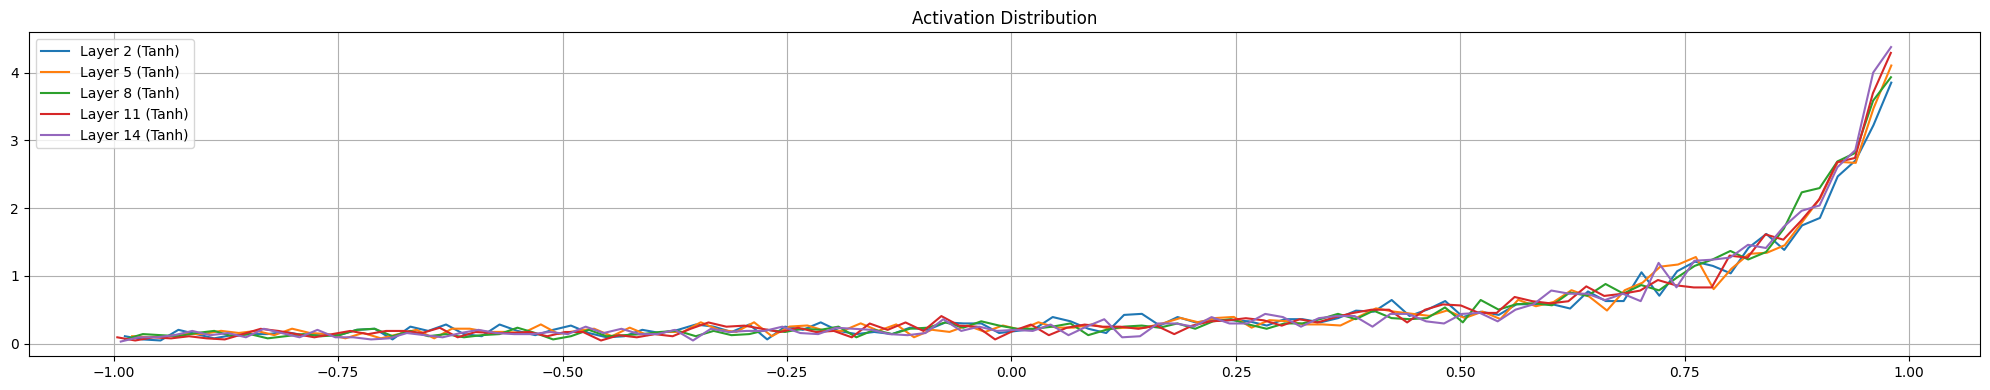

Layer 2 (Tanh): mean +0.000000, std 7.27e-03
Layer 5 (Tanh): mean -0.000000, std 5.98e-03
Layer 8 (Tanh): mean +0.000000, std 5.78e-03
Layer 11 (Tanh): mean +0.000000, std 5.23e-03
Layer 14 (Tanh): mean -0.000000, std 5.13e-03


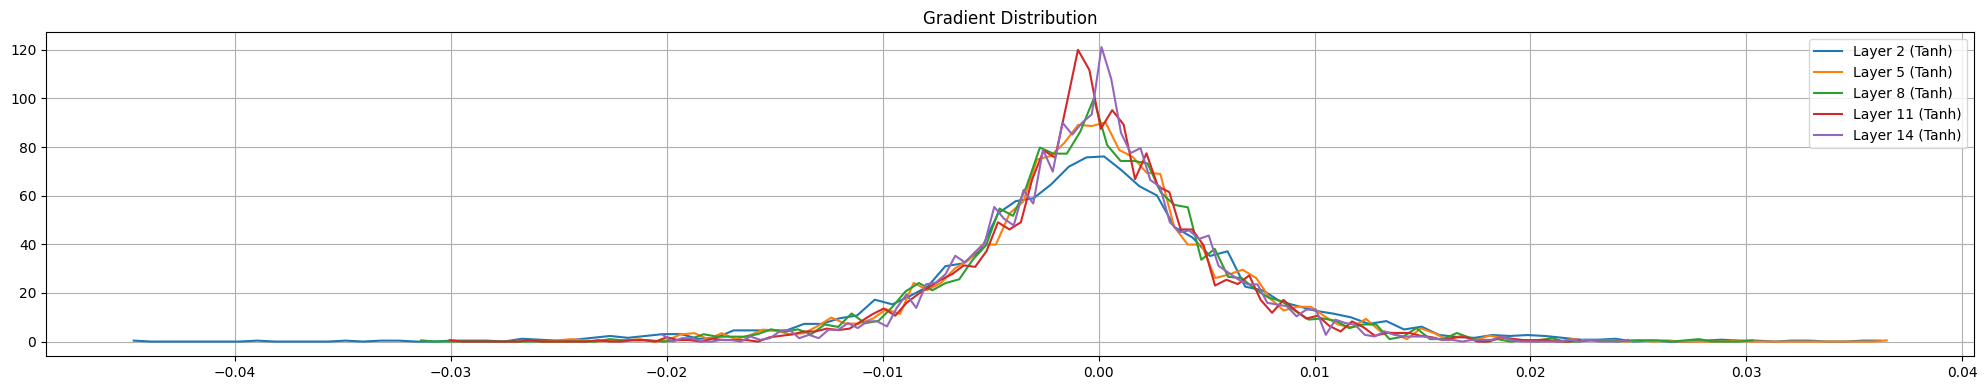

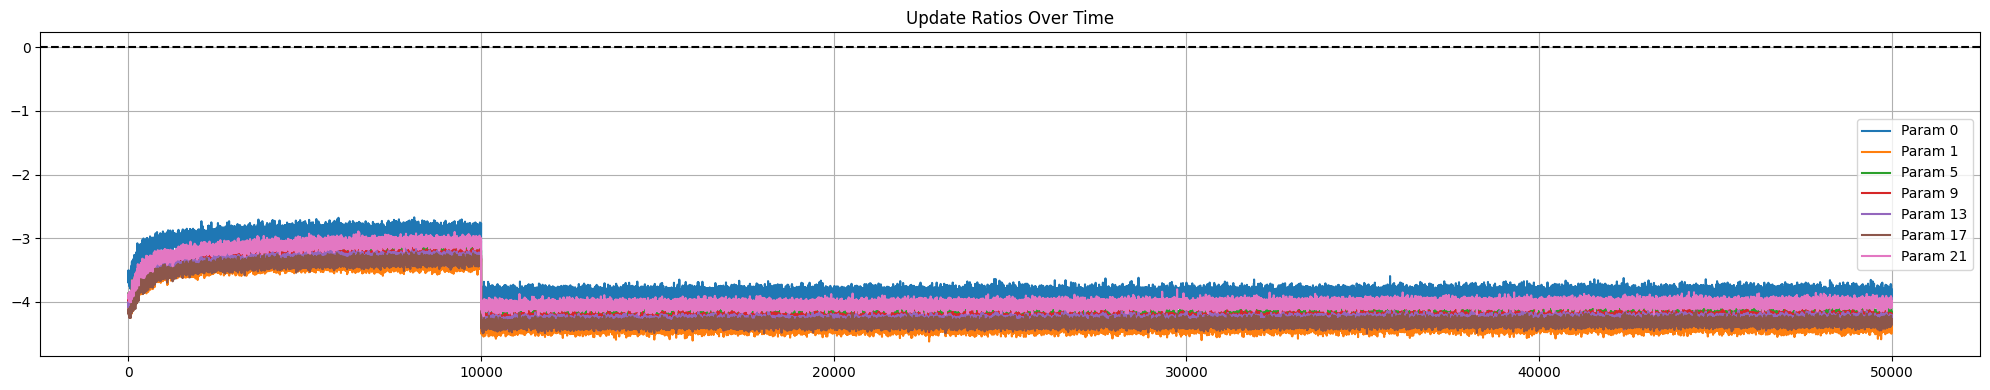

Weight (27, 10) | mean +0.000000 | std 1.39e-02 | grad:data ratio 1.42e-02
Weight (30, 100) | mean -0.000023 | std 4.38e-03 | grad:data ratio 4.55e-03
Weight (100, 100) | mean -0.000003 | std 3.70e-03 | grad:data ratio 7.01e-03
Weight (100, 100) | mean -0.000039 | std 3.38e-03 | grad:data ratio 6.37e-03
Weight (100, 100) | mean +0.000038 | std 3.23e-03 | grad:data ratio 6.09e-03
Weight (100, 100) | mean -0.000034 | std 2.77e-03 | grad:data ratio 5.20e-03
Weight (100, 27) | mean +0.000103 | std 5.37e-03 | grad:data ratio 1.02e-02


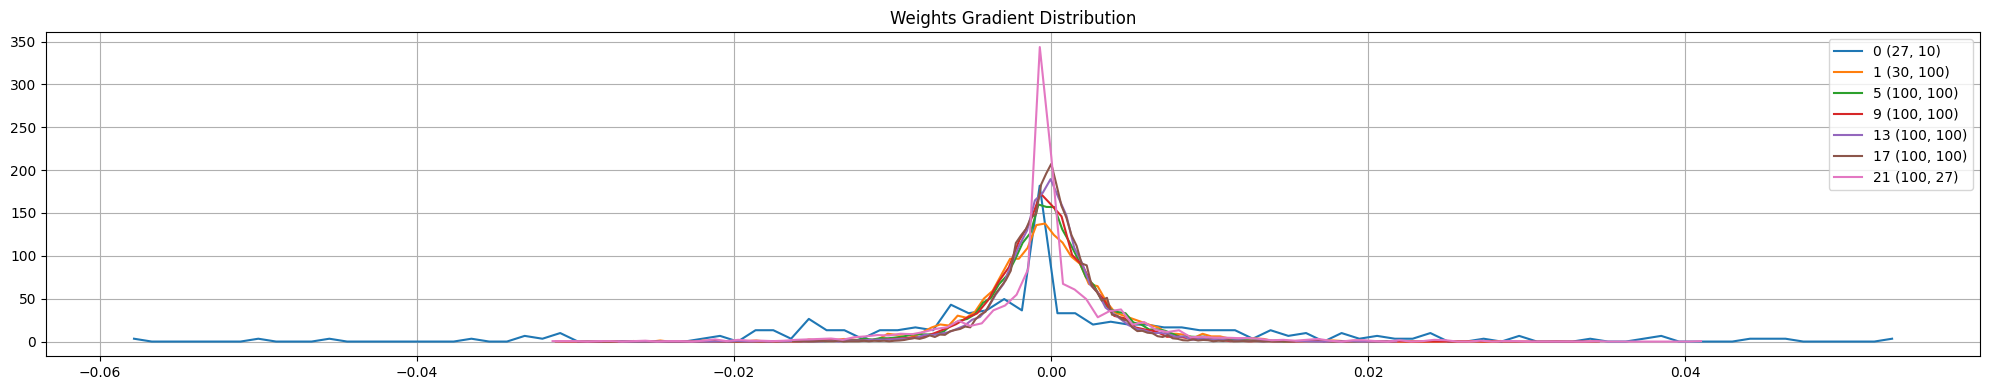

In [20]:
plot_histograms(layers, "Activation Distribution", attr='out')
plot_histograms(layers, "Gradient Distribution", attr='out', is_grad=True)
plot_update_ratios(parameters, ud)
plot_weight_gradients(parameters)


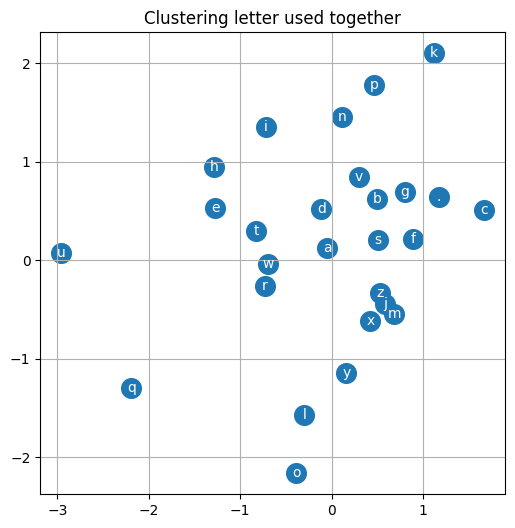

In [21]:
plt.figure(figsize=(6,6))
plt.scatter(C[:,0].data, C[:,1].data, s = 200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha = "center", va = "center", color = "white")

plt.title("Clustering letter used together")
plt.grid("minor")

### Part 5: Build a WaveNet

- Implement more complex architecure: WaveNet

**Result**:
- Previous loss: **2.31**
- Result: **1.89**

In [49]:
# Hyperparameters
block_size = 8 
n_embd     = 24
n_hidden   = 128
max_steps  = 50000
batch_size = 32

# Construction data set
Xtr, Ytr   = build_dataset(words[:n1],  block_size, stoi)  # 80%
Xdev, Ydev = build_dataset(words[n1:n2],block_size, stoi)  # 10%
Xte, Yte   = build_dataset(words[n2:],  block_size, stoi)  # 10%

# Model
model = Sequential([
    Embedding(vocab_size, n_embd),
    FlattenConsecutive(2), Linear(n_embd * 2,n_hidden, bias = False), BatchNorm1D(n_hidden), Tanh(),
    FlattenConsecutive(2), Linear(n_hidden * 2,n_hidden, bias = False), BatchNorm1D(n_hidden), Tanh(),
    FlattenConsecutive(2), Linear(n_hidden * 2,n_hidden, bias = False), BatchNorm1D(n_hidden), Tanh(),
    Linear(n_hidden,vocab_size)
])

with torch.no_grad():
    model.layers[-1].weight *= 0.1 # Reduce confidence last layer
parameters = model.parameters()
print(f"There is a total of {sum(p.nelement() for p in parameters)} parameters")

for p in parameters:
    p.requires_grad = True # Allow gradients to be calculated

There is a total of 76579 parameters


In [53]:
# Optimization
lossi = []
ud    = []

for i in range(max_steps):

    # mini batch construct 
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator = g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
    # forward pass
    logits = model(Xb)
    loss = F.cross_entropy(logits,Yb)    # cross entropy loss
    # backward pass
    for layer in layers:
        layer.out.retain_grad()
    for p in parameters:
        p.grad = None
    loss.backward()
    # update
    lr = 0.1 if i < 10000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad
    with torch.no_grad():
        ud.append([(lr * p.grad.std() / p.data.std()).log10().item() for p in parameters])
    
    # track stats
    if i %  10000 == 0: # print every once in a while
        print(f"{i:7d}/{max_steps:7d}: {loss.item():.4f}")
    lossi.append(loss.log10().item())

      0/  50000: 2.4355
  10000/  50000: 2.0085
  20000/  50000: 2.0184
  30000/  50000: 2.0208
  40000/  50000: 1.8035


In [ ]:
# Put layers into eval mode for inference
for layer in layers:
    layer.training = False

# evaluate the loss
@torch.no_grad()
def split_loss(split):
    x,y = {
        "train": (Xtr,Ytr),
        "val": (Xdev,Ydev),
        "test":(Xte,Yte),
    }[split]
    logits = model(x)
    loss = F.cross_entropy(logits,y)
    print(split,loss.item())

split_loss("train")

train 1.8952172994613647


: 

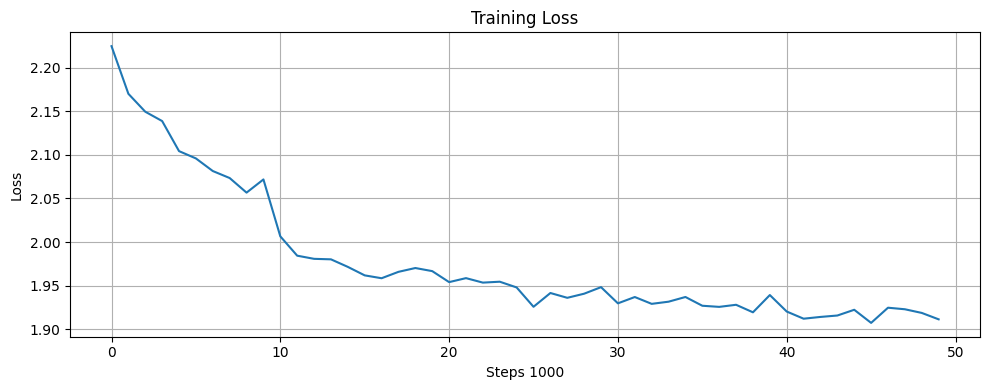

In [62]:
smoothed_loss = 10 ** torch.tensor(lossi).view(-1, 1000).mean(1)

plt.figure(figsize=(10, 4))
plt.plot(smoothed_loss)
plt.title("Training Loss")
plt.xlabel("Steps 1000")
plt.ylabel("Loss")
plt.grid(True)
plt.tight_layout()
plt.show()